In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import warnings
warnings.filterwarnings(action='ignore')

2024-04-07 13:04:56.293472: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 13:04:56.422739: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 13:04:56.924109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 13:04:58.935253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 2nd Attention

Считаем, что в каждый момент времени набор временных рядов задается матрицей $\textbf{X} \in R^{n \times L}$:

$$
\begin{equation}
\textbf{X} = \left( \begin{array}{cccc}
x^{(1)}_{t - \text{L} + 1} & x^{(1)}_{t - \text{L} + 2} & \ldots & x^{(1)}_{t} \\
x^{(2)}_{t - \text{L} + 1} & x^{(2)}_{t - \text{L} + 2} & \ldots & x^{(2)}_{t} \\
\ldots & \ldots & \ldots & \ldots \\
x^{(n)}_{t - \text{L} + 1} & x^{(n)}_{t - \text{L} + 2} & \ldots & x^{(n)}_{t}.
\end{array}\right)
\end{equation}
$$

$i$-й столбец матрицы $\textbf{X}$ обозначим через вектор $\textbf{y}^{i}$. А $i$-ю строку матрицы $\textbf{X}$ обозначим через вектор $\textbf{x}^{(i)}$.   В каждый момент времени поставим в соответствие данному набору матрицу $\Sigma_t \in R^{\text{n} \times \text{n}}$, элементы которой описывают взаимосвязь различных компонент набора временных рядов. Рассмотрим три способа построения данной матрицы.

#### Способ № 1

$$
\begin{equation}
\Sigma_t^{1} = \dfrac{1}{L}\sum\limits_{i = 1}^{L} \textbf{y}^{i} \textbf{y}^{iT}
\end{equation}
$$

#### Способ № 2

Введем вектор $\mathbf{m} \in R^{\text{n}}$ следующим образом:

$$
\begin{equation}
\mathbf{m}_j = \dfrac1L \sum\limits_{i = 1}^{L} \textbf{y}^{i}_j.
\end{equation}
$$

А теперь матрицу $\Sigma_t^{2}$, при построении которой, в отличие от $\Sigma_t^{1}$, процентрируем векторы $\textbf{y}^{i}$ с помощью  $\textbf{m}$: 

$$
\begin{equation}
\Sigma_t^{2} = \dfrac{1}{L}\sum\limits_{i = 1}^{L} (\textbf{y}^{i} - \textbf{m}) (\textbf{y}^{i} - \textbf{m})^T
\end{equation}
$$

#### Способ № 3

Для каждой строки $\textbf{x}^{(j)}$, $j \in {1, \ldots, n}$ матрицы $\textbf{X}$ введем величину:

$$
\begin{equation}
\sigma_j = \sqrt{\dfrac{1}{L} \sum\limits_{i = 1}^L (\textbf{x}^{(j)}_i - \textbf{m}_i)^2}.
\end{equation}
$$

Теперь введем матрицу $\Sigma_t^3$ следующим образом:

$$
\begin{equation}
(\Sigma_t^{3})_{ij} = \dfrac{(\Sigma_t^{2})_{ij}}{\sigma_i \sigma_j}.
\end{equation}
$$

# 1. Синтетические временные ряды

In [94]:
num_of_series = 4 # количество временных рядов
ts_len = 200 # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma

In [95]:
def sine_ts(n_points, num_of_series, dimension=1, n_periods=4, ampl=10, period_ratio=1/5):
    '''
        Данная функция создает набор из num_of_series временных рядов размера n_points. 
        Временные ряды представляют собой отличающиеся по амплитуде и фазе синусы. 
        Получаемый набор имеет высокую попарную корреляцию.
    '''
    sigma = ampl / 10
    time = np.arange(1, n_points+1)
    series_sines = []
    for i in range(1, num_of_series + 1):
        series = (ampl / 2 * i / 5) * np.sin(2 * np.pi * n_periods * time / n_points + i * 2 * np.pi / num_of_series).reshape(-1, 1)
        series_sines.append(series)
    data = np.hstack(series_sines) + sigma * np.random.randn(n_points, num_of_series)
    column_names = [f'Sine_{i}' for i in range(num_of_series)]
    ts = pd.DataFrame(data, index=time, columns=column_names)
    return ts

In [96]:
ts = sine_ts(ts_len, num_of_series)

In [8]:
def corr_matrix(ts, L, option=3):
    
    '''
        Данная функция принимает на вход набор временных рядов, ширину окна и возвращает массив X.
        X[i] - матрица корреляции компонент временного ряда в момент времени i + L + 1
    '''

    X = []

    ts_size = ts.shape[0] # Длина временных рядов
    ts_components = ts.shape[1] # Количество компонент вр.р. в наборе
    
    for i in range(ts_size - L): # По каждым последовательным L отсчетам времени строим матрицу Сигма
        sigma = np.zeros((ts_components, ts_components)) # Инициализируем нулями
        m = np.zeros((ts_components, 1)) # Вектор матожидания тоже инициализируем нулями

        if option == 2 or option == 3:
            for k in range(ts_components): # Вычисляем вектор матожидания
                sum_ = 0
                for l in range(L):
                    sum_ += ts.iloc[i + l, k] / L
                m[k, 0] = sum_

        if option == 3:
            sqrt_dispercion = [] # Заводим массив, где будут храниться корни из дисперсии для каждого момента времени из [i, i + L - 1]
            for k in range(ts_components): # Рассчитываем вектор корней из дисперсии
                sum_ = 0
                for time in range(L):
                    sum_ += ((ts.iloc[i + time, k] - m[k, 0]) ** 2) / L

                sqrt_dispercion.append(np.sqrt(sum_))

        for j in range(L): # Считаем матрицу Sigma_2
            vector = ts.iloc[i + j, :ts_components].values
            vector = vector.reshape(-1, 1)
            sigma += np.outer(vector - m, (vector - m).T) / L

        if option == 3:
            for row in range(ts_components): # Делим [row, col] - ый элемент матрицы на соответствующие корни из дисперсии, получаем матрицу корреляции, т.е Sigma_3
                for col in range(ts_components):
                    sigma[row, col] = sigma[row, col] / (sqrt_dispercion[row] * sqrt_dispercion[col])
        
        X.append(sigma) # Добавляем полученную матрицу в массив входов 

    X_len = len(X)

    return X

In [9]:
def corr_mtx_to_ts(X, L):

    '''
        Данная функция получает на вход массив матриц корреляции X 
        (X[i] - матрица корреляции компонент временного ряда в момент времени i + L + 1) и ширину окна L.
        Далее массив преобразуется в набор временных рядов, состоящий из n(n - 1) / 2 компонент,
        где каждая компонента - это изменение корреляции между временными рядами исходного набора.
    '''
    
    corr_data = []
    X_size = len(X)
    for i in range(X_size):
        upper_triangle_indices = np.triu_indices(X[i].shape[0], k=1)
        upper_triangle_elements = X[i][upper_triangle_indices]
        corr_data.append(upper_triangle_elements)
    column_names = []

    for i in range(1, num_of_series + 1):
        for j in range(i + 1, num_of_series + 1):
            column_names.append(f'corr({i}, {j})')

    time = np.arange(1 + L, X_size + 1 + L)
    corr_ts = pd.DataFrame(corr_data, index=time, columns=column_names)
    return corr_ts

# 1.1 Вид изменения корреляции при различных способах подсчета $\Sigma$ 

In [97]:
X_1 = corr_matrix(ts, L, option=1) # Создаем массив матриц корреляции при трех различных подсчетах Sigma
X_2 = corr_matrix(ts, L, option=2)
X_3 = corr_matrix(ts, L, option=3)

corr_ts_1 = corr_mtx_to_ts(X_1, L) # Получаем соответствующие временные ряды
corr_ts_2 = corr_mtx_to_ts(X_2, L)
corr_ts_3 = corr_mtx_to_ts(X_3, L)

In [98]:
time = [i for i in range(1 + L, ts_len + 1)] # Ось времени

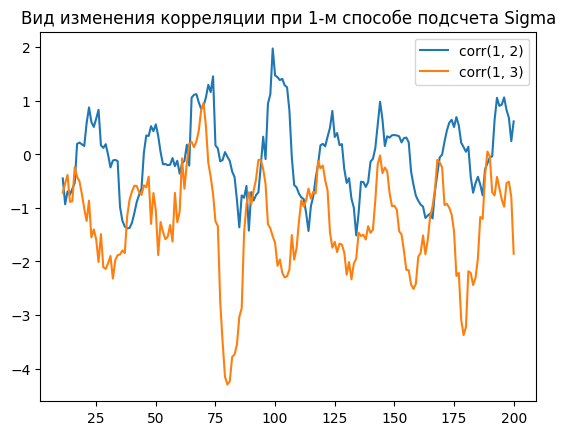

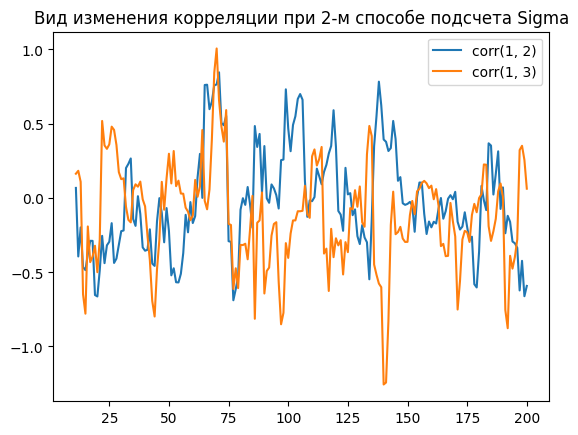

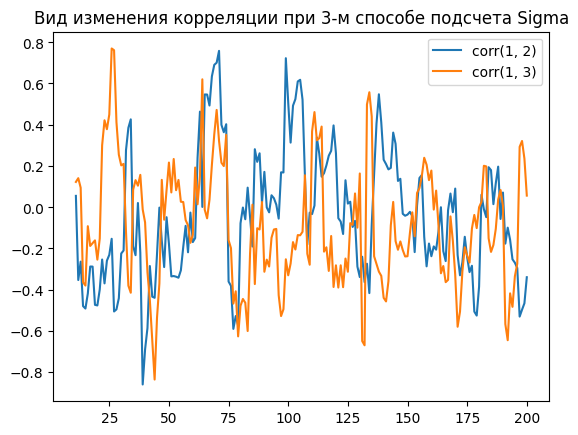

In [99]:
plt.plot(time, corr_ts_1.iloc[:, 0], label="corr(1, 2)")
plt.plot(time, corr_ts_1.iloc[:, 1], label="corr(1, 3)")
plt.title("Вид изменения корреляции при 1-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(time, corr_ts_2.iloc[:, 0], label="corr(1, 2)")
plt.plot(time, corr_ts_2.iloc[:, 1], label="corr(1, 3)")
plt.title("Вид изменения корреляции при 2-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(time, corr_ts_3.iloc[:, 0], label="corr(1, 2)")
plt.plot(time, corr_ts_3.iloc[:, 1], label="corr(1, 3)")
plt.title("Вид изменения корреляции при 3-м способе подсчета Sigma")
plt.legend()
plt.show()

# 1.2 Прогнозирование набора корреляций с помощью LSTM 

## 1.2.1 Реализация LSTM

In [2]:
def scalling(ts):
    '''
        Данная функция переводит значения набора временных рядов в интервал (-1, 1). 
        Возвращает отмасштабированный ряд и словарь скаллеров для дальнейшего обратного преобразования.
    '''
    scalled_ts = ts
    scalers = {}
    for i in ts.columns:
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(scalled_ts[i].values.reshape(-1,1))
        s_s = np.reshape(s_s,len(s_s))
        scalers['scaler_'+ i] = scaler
        scalled_ts[i] = s_s
    return scalled_ts, scalers


def split_series(series, n_past, n_future):

    '''
        Данная функция по параметрам:
            n_past - количество прошлых значений, используемых для прогноза следующих значений,
            n_future - количество прогнозируемых значений,
        разбивает временной ряд на пары (X, y), для дальнейшего обучения модели. 
        X - вход, предыдущие n_past значений набора временного ряда. 
        y - выход, следующие n_future значений временного ряда.
    '''
    
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)


def get_split_series(train_ts, test_ts, n_past, num_of_series, n_future=1):
    X_train, y_train = split_series(train_ts.values,n_past, n_future)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_of_series))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], num_of_series))
    X_test, y_test = split_series(test_ts.values,n_past, n_future)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_of_series))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], num_of_series))
    return X_train, y_train, X_test, y_test


def get_e2d2_model(n_past, num_of_series, n_future=1):
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, num_of_series))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_of_series))(decoder_l2)
    
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    return model_e2d2


def train_model(model, X_train, y_train, X_test, y_test, reduce_lr, epochs=10, batch_size=32):
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),batch_size=batch_size,verbose=0,callbacks=[reduce_lr])
    forecast = model.predict(X_test)
    return forecast


def inverse_scalling(columns, scalers, ts):
    for index, i in enumerate(columns):
        scaler = scalers['scaler_'+i]
        ts[:, :, index] = scaler.inverse_transform(ts[:,:,index])
    return ts


def MAE_MSE_avg(forecast_ts, test_ts, num_of_series):
    sum_mape = 0
    sum_mse = 0
    for i in range(num_of_series):
        ytrue = test_ts.iloc[:, i].values
        yhat = forecast_ts.iloc[:, i].values
        mae = MAE(ytrue, yhat)
        mse = MSE(ytrue, yhat)
        sum_mape += mae
        sum_mse += mse
    return sum_mape / num_of_series, sum_mse / num_of_series

In [3]:
def forecast(ts, n_past, num_of_series, train_test_ratio=0.7):
    split_point = int(ts.shape[0] * train_test_ratio)
    train_ts, test_ts = ts[1:split_point], ts[split_point:]

    train, scallers_train = scalling(train_ts)
    test, scallers_test = scalling(test_ts)
    
    X_train, y_train, X_test, y_test = get_split_series(train, test, n_past, num_of_series)

    model_e2d2 = get_e2d2_model(n_past, num_of_series)
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    pred_e2d2 = train_model(model_e2d2, X_train, y_train, X_test, y_test, reduce_lr)

    pred_e2d2 = inverse_scalling(train_ts.columns, scallers_test, pred_e2d2)
    y_train = inverse_scalling(train_ts.columns, scallers_train, y_train)
    y_test = inverse_scalling(train_ts.columns, scallers_test, y_test)

    pred_e2d2 = pd.DataFrame(pred_e2d2.reshape(ts.shape[0] - split_point - n_past, num_of_series))  
    y_test = pd.DataFrame(y_test.reshape(ts.shape[0] - split_point - n_past, num_of_series)) 

    return pred_e2d2, y_test

## 1.2.2 Выполнение короткого прогноза с 4 временными рядами

In [100]:
num_of_series = 4 # количество временных рядов
ts_len = 200 # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma
num_of_corr_series = int(num_of_series * (num_of_series - 1) / 2) # Количество временных рядов в наборе
n_past = L # Ширина окна прогноза
train_test_ratio = 0.75

In [101]:
forecast_corr_1, actual_corr_1 = forecast(corr_ts_1, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_2, actual_corr_2 = forecast(corr_ts_2, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_3, actual_corr_3 = forecast(corr_ts_3, n_past, num_of_corr_series, train_test_ratio)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/stepWARNING:tensorflow:6 out of the last 54 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x79e91ed62a70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step


In [102]:
MAE_avg_1, MSE_avg_1 = MAE_MSE_avg(forecast_corr_1, actual_corr_1, num_of_corr_series) # вычисление средних ошибок прогноза MAE, MSE
MAE_avg_2, MSE_avg_2 = MAE_MSE_avg(forecast_corr_2, actual_corr_2, num_of_corr_series)
MAE_avg_3, MSE_avg_3 = MAE_MSE_avg(forecast_corr_3, actual_corr_3, num_of_corr_series)

In [103]:
print(f'Первый способ: MAE = {MAE_avg_1}, MSE = {MSE_avg_1}')
print(f'Второй способ: MAE = {MAE_avg_2}, MSE = {MSE_avg_2}')
print(f'Третий способ: MAE = {MAE_avg_3}, MSE = {MSE_avg_3}')

Первый способ: MAE = 0.6451691709295376, MSE = 0.9814685199997162
Второй способ: MAE = 0.31366900286229227, MSE = 0.15225450231700743
Третий способ: MAE = 0.21145461647424382, MSE = 0.06560126289121018


In [104]:
forecast_corr_1 = forecast_corr_1.set_index(forecast_corr_1.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_2 = forecast_corr_2.set_index(forecast_corr_2.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_3 = forecast_corr_3.set_index(forecast_corr_3.index + int(ts_len * train_test_ratio) + L + 1)

In [105]:
split_point = int((ts_len * train_test_ratio))

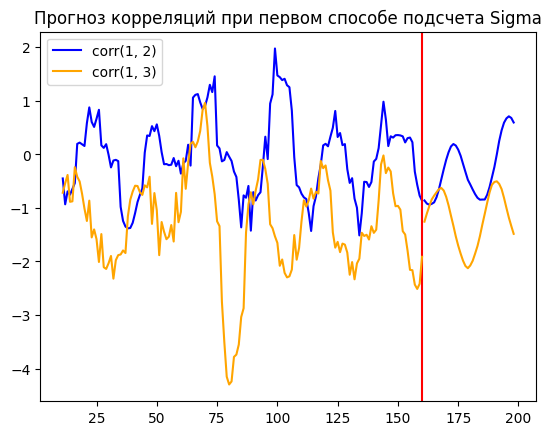

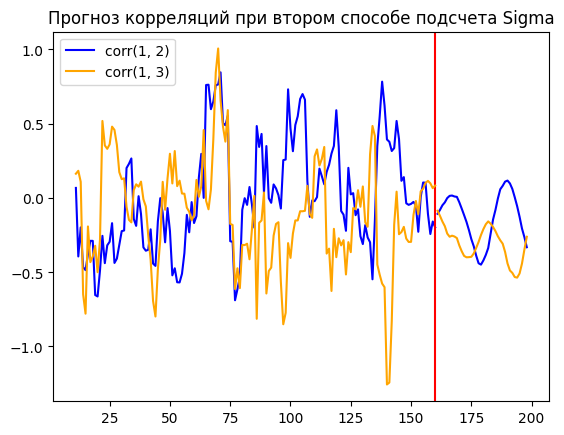

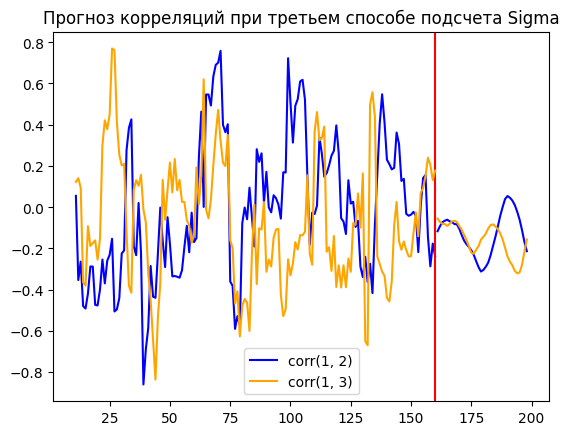

In [110]:
plt.plot(corr_ts_1.iloc[:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_1.iloc[:, 0],  color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_1.iloc[:split_point, 1], label="corr(1, 3)", color='orange')
plt.plot(forecast_corr_1.iloc[:, 1], color='orange')

plt.title("Прогноз корреляций при первом способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_2.iloc[:, 0], color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_2.iloc[:split_point, 1], label="corr(1, 3)", color='orange')
plt.plot(forecast_corr_2.iloc[:, 1], color='orange')

plt.title("Прогноз корреляций при втором способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_3.iloc[:, 0],  color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_3.iloc[:split_point, 1], label="corr(1, 3)", color='orange')
plt.plot(forecast_corr_3.iloc[:, 1],  color='orange')

plt.title("Прогноз корреляций при третьем способе подсчета Sigma")
plt.legend()
plt.show()

## 1.2.3 Выполнение длинного прогноза с 4 временными рядами

In [157]:
num_of_series = 4 # количество временных рядов
ts_len = 1000 # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma
num_of_corr_series = int(num_of_series * (num_of_series - 1) / 2) # Количество временных рядов в наборе
n_past = L # Ширина окна прогноза
train_test_ratio = 0.7
split_point = int((ts_len * train_test_ratio))

In [150]:
ts_long = sine_ts(ts_len, num_of_series)

In [152]:
X_1 = corr_matrix(ts_long, L, option=1) # Создаем массив матриц корреляции при трех различных подсчетах Sigma
X_2 = corr_matrix(ts_long, L, option=2)
X_3 = corr_matrix(ts_long, L, option=3)

corr_ts_1 = corr_mtx_to_ts(X_1, L) # Получаем соответствующие временные ряды
corr_ts_2 = corr_mtx_to_ts(X_2, L)
corr_ts_3 = corr_mtx_to_ts(X_3, L)

In [153]:
forecast_corr_1, actual_corr_1 = forecast(corr_ts_1, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_2, actual_corr_2 = forecast(corr_ts_2, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_3, actual_corr_3 = forecast(corr_ts_3, n_past, num_of_corr_series, train_test_ratio)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


In [154]:
MAE_avg_1, MSE_avg_1 = MAE_MSE_avg(forecast_corr_1, actual_corr_1, num_of_corr_series) # вычисление средних ошибок прогноза MAE, MSE
MAE_avg_2, MSE_avg_2 = MAE_MSE_avg(forecast_corr_2, actual_corr_2, num_of_corr_series)
MAE_avg_3, MSE_avg_3 = MAE_MSE_avg(forecast_corr_3, actual_corr_3, num_of_corr_series)

In [155]:
print(f'Первый способ: MAE = {MAE_avg_1}, MSE = {MSE_avg_1}')
print(f'Второй способ: MAE = {MAE_avg_2}, MSE = {MSE_avg_2}')
print(f'Третий способ: MAE = {MAE_avg_3}, MSE = {MSE_avg_3}')

Первый способ: MAE = 0.5517139783240311, MSE = 0.49999486726040415
Второй способ: MAE = 0.16742709918425125, MSE = 0.045178884148119124
Третий способ: MAE = 0.16949349075488565, MSE = 0.04629141428691009


In [156]:
forecast_corr_1 = forecast_corr_1.set_index(forecast_corr_1.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_2 = forecast_corr_2.set_index(forecast_corr_2.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_3 = forecast_corr_3.set_index(forecast_corr_3.index + int(ts_len * train_test_ratio) + L + 1)

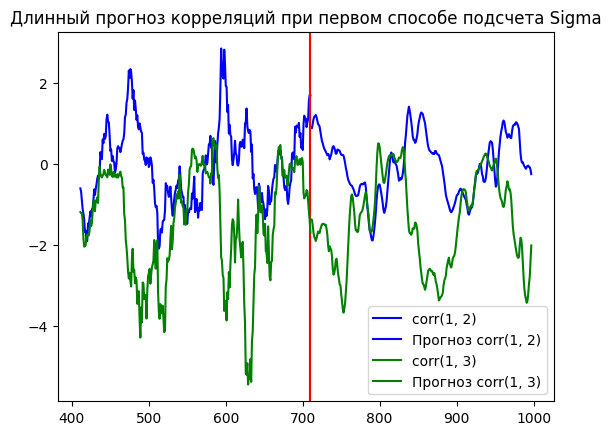

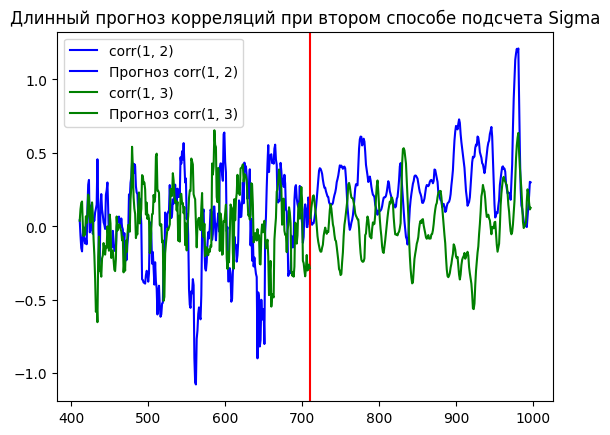

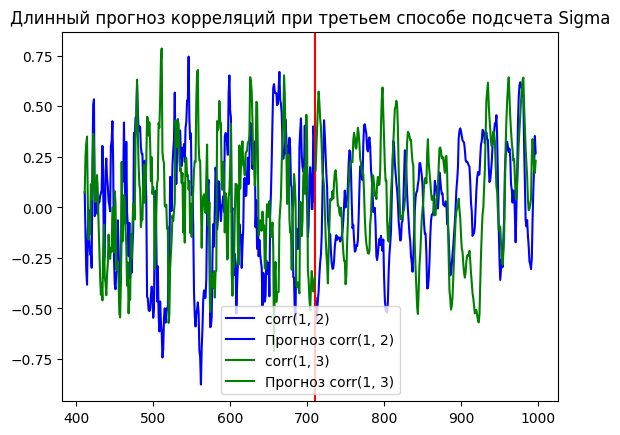

In [159]:
plt.plot(corr_ts_1.iloc[400:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_1.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_1.iloc[400:split_point, 1], label="corr(1, 3)", color='g')
plt.plot(forecast_corr_1.iloc[:, 1], label="Прогноз corr(1, 3)", color='g')

plt.title("Длинный прогноз корреляций при первом способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[400:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_2.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_2.iloc[400:split_point, 1], label="corr(1, 3)", color='g')
plt.plot(forecast_corr_2.iloc[:, 1], label="Прогноз corr(1, 3)", color='g')

plt.title("Длинный прогноз корреляций при втором способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[400:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_3.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_3.iloc[400:split_point, 1], label="corr(1, 3)", color='g')
plt.plot(forecast_corr_3.iloc[:, 1], label="Прогноз corr(1, 3)", color='g')

plt.title("Длинный прогноз корреляций при третьем способе подсчета Sigma")
plt.legend()
plt.show()

## 1.2.4 Выполнение длинного прогноза с 24 временными рядами

In [81]:
num_of_series = 24 # количество временных рядов
ts_len = 1000 # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma
num_of_corr_series = int(num_of_series * (num_of_series - 1) / 2) # Количество временных рядов в наборе
n_past = L # Ширина окна прогноза
train_test_ratio = 0.7
split_point = int((ts_len * train_test_ratio))

In [84]:
ts_long = sine_ts(ts_len, num_of_series)

In [85]:
X_1 = corr_matrix(ts_long, L, option=1) # Создаем массив матриц корреляции при трех различных подсчетах Sigma
X_2 = corr_matrix(ts_long, L, option=2)
X_3 = corr_matrix(ts_long, L, option=3)

corr_ts_1 = corr_mtx_to_ts(X_1, L) # Получаем соответствующие временные ряды
corr_ts_2 = corr_mtx_to_ts(X_2, L)
corr_ts_3 = corr_mtx_to_ts(X_3, L)

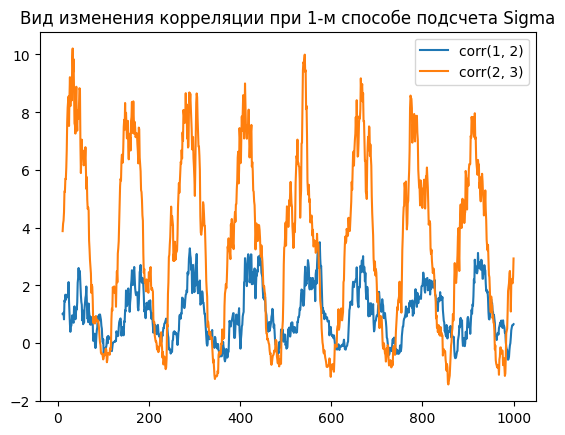

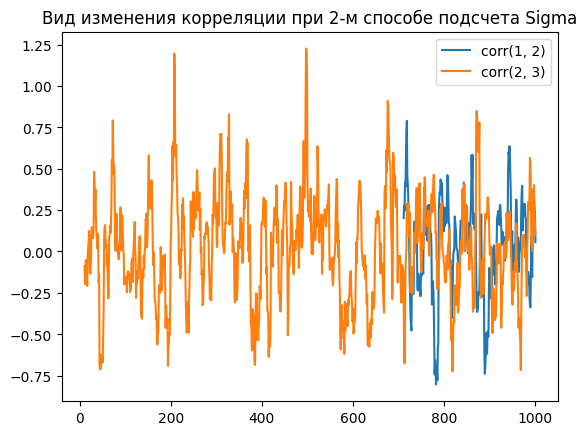

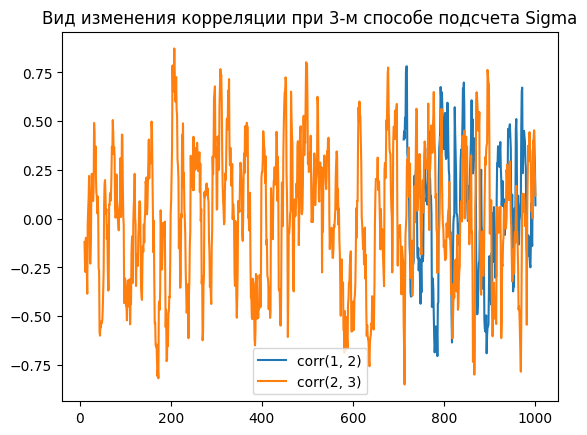

In [89]:
plt.plot(corr_ts_1.iloc[:, 0], label="corr(1, 2)")
plt.plot(corr_ts_1.iloc[:, 24], label="corr(2, 3)")
plt.title("Вид изменения корреляции при 1-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[700:, 0], label="corr(1, 2)")
plt.plot(corr_ts_2.iloc[:, 24], label="corr(2, 3)")
plt.title("Вид изменения корреляции при 2-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[700:, 0], label="corr(1, 2)")
plt.plot(corr_ts_3.iloc[:, 24], label="corr(2, 3)")
plt.title("Вид изменения корреляции при 3-м способе подсчета Sigma")
plt.legend()
plt.show()

In [163]:
forecast_corr_1, actual_corr_1 = forecast(corr_ts_1, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_2, actual_corr_2 = forecast(corr_ts_2, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_3, actual_corr_3 = forecast(corr_ts_3, n_past, num_of_corr_series, train_test_ratio)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


In [164]:
MAE_avg_1, MSE_avg_1 = MAE_MSE_avg(forecast_corr_1, actual_corr_1, num_of_corr_series) # вычисление средних ошибок прогноза MAE, MSE
MAE_avg_2, MSE_avg_2 = MAE_MSE_avg(forecast_corr_2, actual_corr_2, num_of_corr_series)
MAE_avg_3, MSE_avg_3 = MAE_MSE_avg(forecast_corr_3, actual_corr_3, num_of_corr_series)

In [165]:
print(f'Первый способ: MAE = {MAE_avg_1}, MSE = {MSE_avg_1}')
print(f'Второй способ: MAE = {MAE_avg_2}, MSE = {MSE_avg_2}')
print(f'Третий способ: MAE = {MAE_avg_3}, MSE = {MSE_avg_3}')

Первый способ: MAE = 4.340460478331357, MSE = 36.92828478266238
Второй способ: MAE = 0.39396198595717125, MSE = 0.2571188153033009
Третий способ: MAE = 0.2749826964236843, MSE = 0.11627845852044545


In [166]:
forecast_corr_1 = forecast_corr_1.set_index(forecast_corr_1.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_2 = forecast_corr_2.set_index(forecast_corr_2.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_3 = forecast_corr_3.set_index(forecast_corr_3.index + int(ts_len * train_test_ratio) + L + 1)

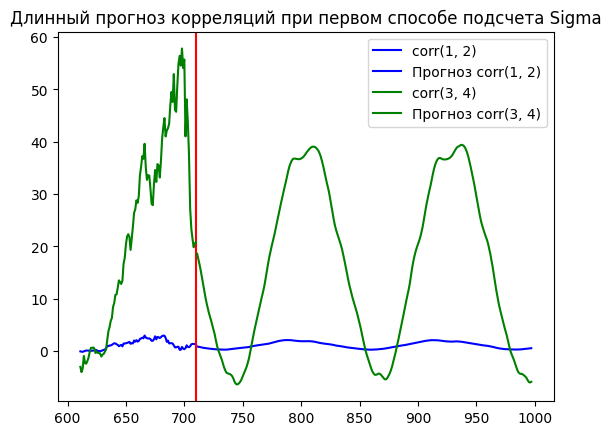

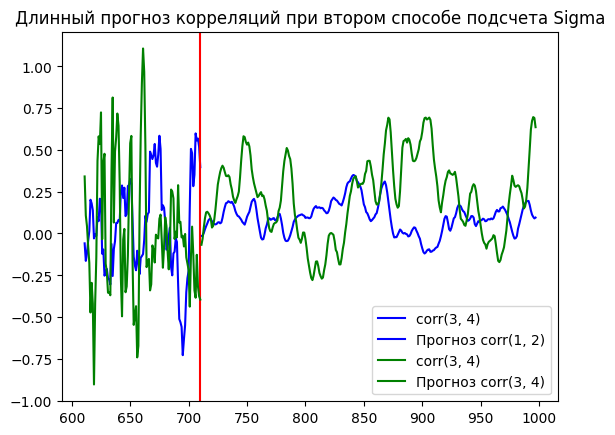

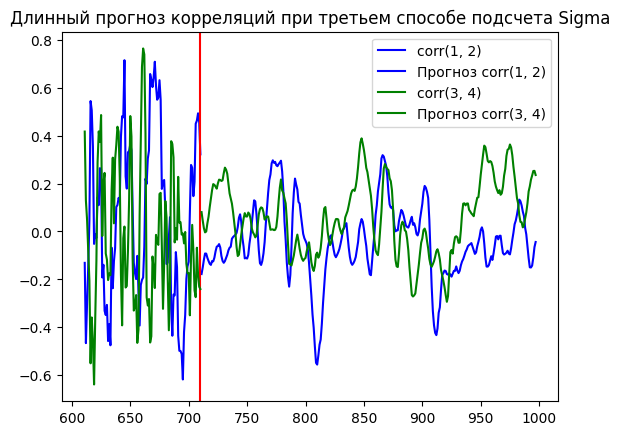

In [169]:
plt.plot(corr_ts_1.iloc[600:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_1.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_1.iloc[600:split_point, 44], label="corr(3, 4)", color='g')
plt.plot(forecast_corr_1.iloc[:, 44], label="Прогноз corr(3, 4)", color='g')

plt.title("Длинный прогноз корреляций при первом способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[600:split_point, 0], label="corr(3, 4)", color='b')
plt.plot(forecast_corr_2.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_2.iloc[600:split_point, 44], label="corr(3, 4)", color='g')
plt.plot(forecast_corr_2.iloc[:, 44], label="Прогноз corr(3, 4)", color='g')

plt.title("Длинный прогноз корреляций при втором способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[600:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_3.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_3.iloc[600:split_point, 44], label="corr(3, 4)", color='g')
plt.plot(forecast_corr_3.iloc[:, 44], label="Прогноз corr(3, 4)", color='g')

plt.title("Длинный прогноз корреляций при третьем способе подсчета Sigma")
plt.legend()
plt.show()

# 2. Реальные временные ряды 1

In [10]:
colnames = ['Time'] + [f'Price{i}' for i in range(24)]

ts_real = pd.read_csv('Погружение временных рядов с высокой волатильностью в метрическое пространство/Данные/GermanSpotPrice.csv', names=colnames, header=None)
ts_real = ts_real.set_index('Time')
ts_real = ts_real.set_index(ts_real.index - 731582)

In [11]:
num_of_series = ts_real.shape[1]
ts_len = ts_real.shape[0] # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma
num_of_corr_series = int(num_of_series * (num_of_series - 1) / 2) # Количество временных рядов в наборе
n_past = L # Ширина окна прогноза
train_test_ratio = 0.7
split_point = int((ts_len * train_test_ratio))

In [12]:
X_1 = corr_matrix(ts_real, L, option=1) # Создаем массив матриц корреляции при трех различных подсчетах Sigma
X_2 = corr_matrix(ts_real, L, option=2)
X_3 = corr_matrix(ts_real, L, option=3)

corr_ts_1 = corr_mtx_to_ts(X_1, L) # Получаем соответствующие временные ряды
corr_ts_2 = corr_mtx_to_ts(X_2, L)
corr_ts_3 = corr_mtx_to_ts(X_3, L)

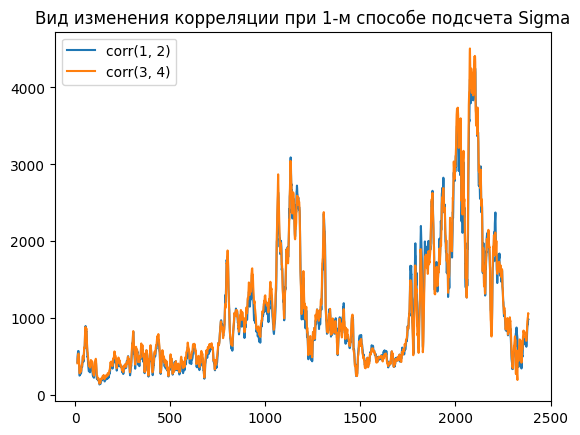

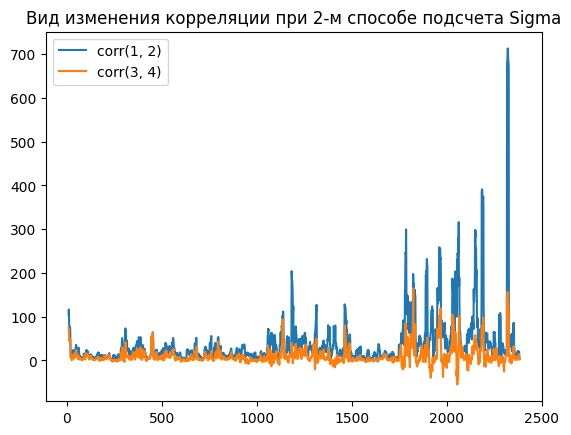

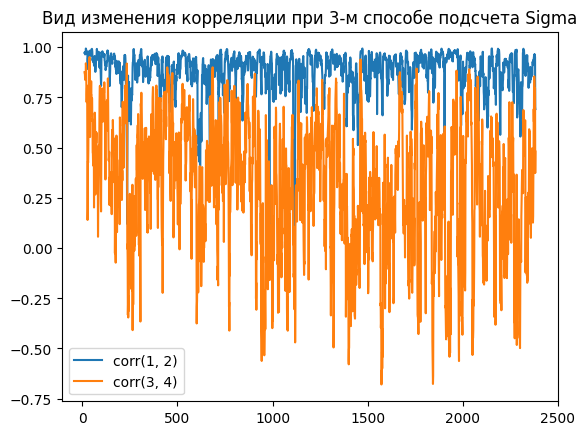

In [13]:
plt.plot(corr_ts_1.iloc[:, 0], label="corr(1, 2)")
plt.plot(corr_ts_1.iloc[:, 44], label="corr(3, 4)")
plt.title("Вид изменения корреляции при 1-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[:, 0], label="corr(1, 2)")
plt.plot(corr_ts_2.iloc[:, 44], label="corr(3, 4)")
plt.title("Вид изменения корреляции при 2-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[:, 0], label="corr(1, 2)")
plt.plot(corr_ts_3.iloc[:, 44], label="corr(3, 4)")
plt.title("Вид изменения корреляции при 3-м способе подсчета Sigma")
plt.legend()
plt.show()

In [14]:
forecast_corr_1, actual_corr_1 = forecast(corr_ts_1, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_2, actual_corr_2 = forecast(corr_ts_2, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_3, actual_corr_3 = forecast(corr_ts_3, n_past, num_of_corr_series, train_test_ratio)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


In [15]:
MAE_avg_1, MSE_avg_1 = MAE_MSE_avg(forecast_corr_1, actual_corr_1, num_of_corr_series) # вычисление средних ошибок прогноза MAE, MSE
MAE_avg_2, MSE_avg_2 = MAE_MSE_avg(forecast_corr_2, actual_corr_2, num_of_corr_series)
MAE_avg_3, MSE_avg_3 = MAE_MSE_avg(forecast_corr_3, actual_corr_3, num_of_corr_series)

In [16]:
print(f'Первый способ: MAE = {MAE_avg_1}, MSE = {MSE_avg_1}')
print(f'Второй способ: MAE = {MAE_avg_2}, MSE = {MSE_avg_2}')
print(f'Третий способ: MAE = {MAE_avg_3}, MSE = {MSE_avg_3}')

Первый способ: MAE = 906.965907499029, MSE = 3400831.6177519965
Второй способ: MAE = 150.8968886063452, MSE = 187241.5437925864
Третий способ: MAE = 0.11791154381072488, MSE = 0.02834318063324067


In [17]:
forecast_corr_1 = forecast_corr_1.set_index(forecast_corr_1.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_2 = forecast_corr_2.set_index(forecast_corr_2.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_3 = forecast_corr_3.set_index(forecast_corr_3.index + int(ts_len * train_test_ratio) + L + 1)

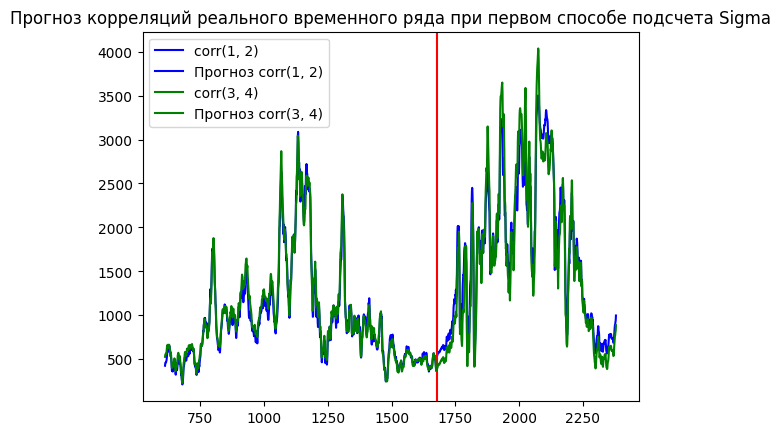

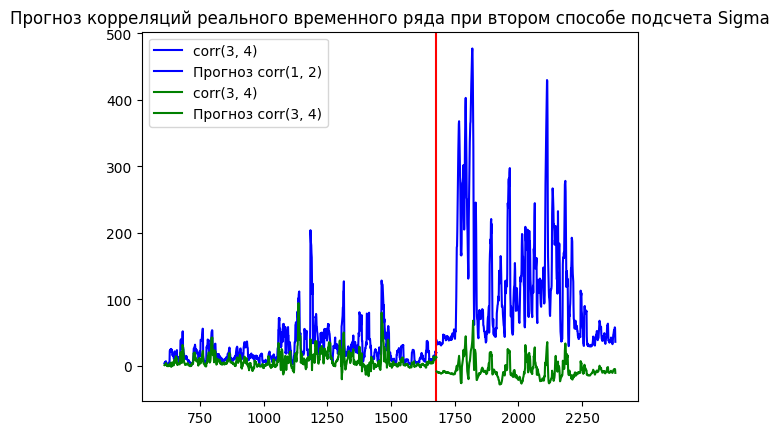

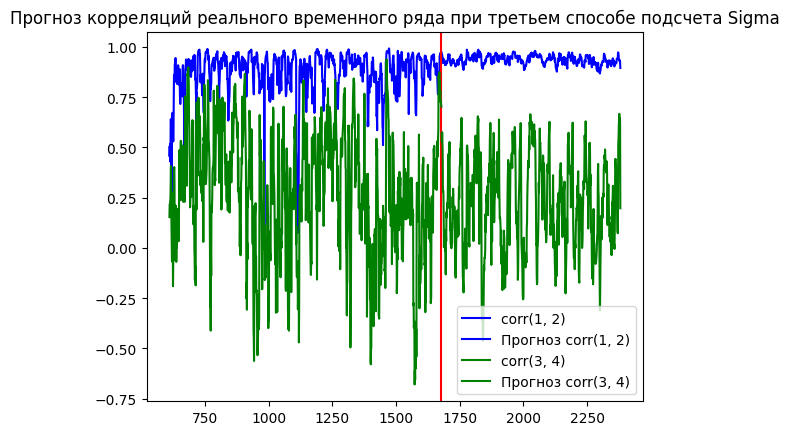

In [18]:
plt.plot(corr_ts_1.iloc[600:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_1.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_1.iloc[600:split_point, 44], label="corr(3, 4)", color='g')
plt.plot(forecast_corr_1.iloc[:, 44], label="Прогноз corr(3, 4)", color='g')

plt.title("Прогноз корреляций реального временного ряда при первом способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[600:split_point, 0], label="corr(3, 4)", color='b')
plt.plot(forecast_corr_2.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_2.iloc[600:split_point, 44], label="corr(3, 4)", color='g')
plt.plot(forecast_corr_2.iloc[:, 44], label="Прогноз corr(3, 4)", color='g')

plt.title("Прогноз корреляций реального временного ряда при втором способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[600:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_3.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_3.iloc[600:split_point, 44], label="corr(3, 4)", color='g')
plt.plot(forecast_corr_3.iloc[:, 44], label="Прогноз corr(3, 4)", color='g')

plt.title("Прогноз корреляций реального временного ряда при третьем способе подсчета Sigma")
plt.legend()
plt.show()

In [32]:
MAE_per_series_1 = [[] for i in range(24)]
MAE_per_series_2 = [[] for i in range(24)]
MAE_per_series_3 = [[] for i in range(24)]

In [33]:
idx = 0

for i in range(1, num_of_series + 1):
    for j in range(i + 1, num_of_series + 1):
        ytrue_1 = actual_corr_1.iloc[:, idx].values
        yhat_1 = forecast_corr_1.iloc[:, idx].values
        ytrue_2 = actual_corr_2.iloc[:, idx].values
        yhat_2 = forecast_corr_2.iloc[:, idx].values
        ytrue_3 = actual_corr_3.iloc[:, idx].values
        yhat_3 = forecast_corr_3.iloc[:, idx].values
        mae_1 = MAE(ytrue_1, yhat_1)
        mae_2 = MAE(ytrue_2, yhat_2)
        mae_3 = MAE(ytrue_3, yhat_3)
        MAE_per_series_1[i - 1].append(mae_1)
        MAE_per_series_1[j - 1].append(mae_1)
        MAE_per_series_2[i - 1].append(mae_2)
        MAE_per_series_2[j - 1].append(mae_2)
        MAE_per_series_3[i - 1].append(mae_3)
        MAE_per_series_3[j - 1].append(mae_3)
        idx += 1

In [34]:
MAE_avg_per_series_1 = []
MAE_avg_per_series_2 = []
MAE_avg_per_series_3 = []

In [35]:
for i in range(num_of_series):
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    for j in range(num_of_series - 1):
        sum_1 += MAE_per_series_1[i][j]
        sum_2 += MAE_per_series_2[i][j]
        sum_3 += MAE_per_series_3[i][j]

    MAE_avg_per_series_1.append(sum_1 / (num_of_series - 1))
    MAE_avg_per_series_2.append(sum_2 / (num_of_series - 1))
    MAE_avg_per_series_3.append(sum_3 / (num_of_series - 1))

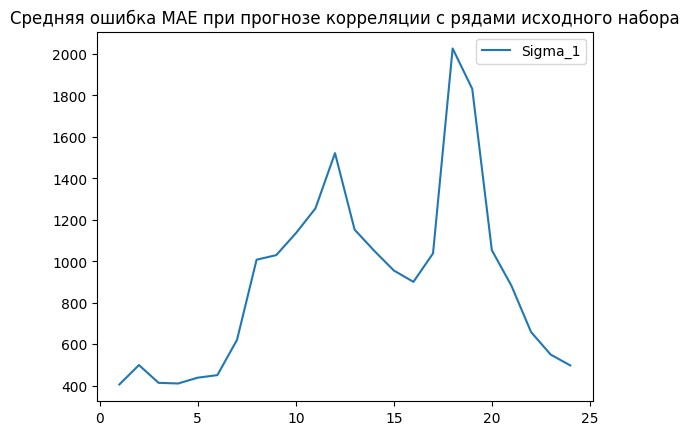

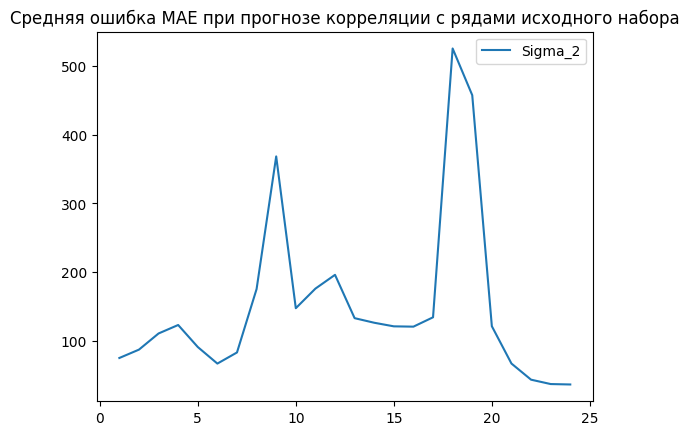

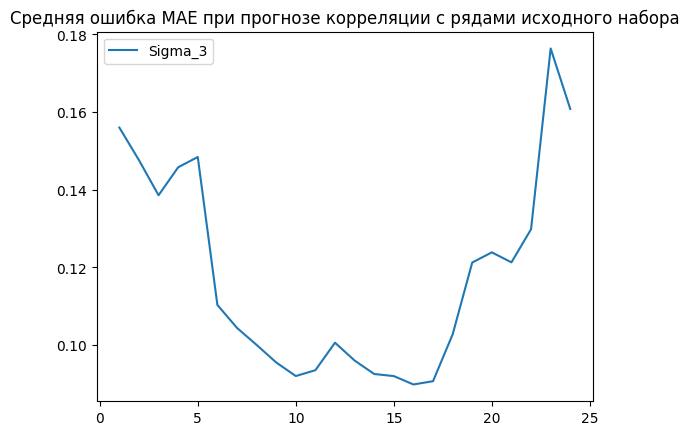

In [37]:
plt.plot([i for i in range(1, num_of_series + 1)], MAE_avg_per_series_1, label="Sigma_1")
plt.title("Средняя ошибка MAE при прогнозе корреляции с рядами исходного набора")
plt.legend()
plt.show()

plt.plot([i for i in range(1, num_of_series + 1)], MAE_avg_per_series_2, label="Sigma_2")
plt.title("Средняя ошибка MAE при прогнозе корреляции с рядами исходного набора")
plt.legend()
plt.show()

plt.plot([i for i in range(1, num_of_series + 1)], MAE_avg_per_series_3, label="Sigma_3")
plt.title("Средняя ошибка MAE при прогнозе корреляции с рядами исходного набора")
plt.legend()
plt.show()

# 3. Реальные временные ряды 2

In [ ]:
'Погружение временных рядов с высокой волатильностью в метрическое пространство/Данные/Elspotprices.csv'

In [46]:
electricity = pd.read_csv('Погружение временных рядов с высокой волатильностью в метрическое пространство/Данные/Elspotprices.csv', delimiter=';', decimal=',')[::-1]
electricity = electricity.reset_index(drop=True)

# Convert to datetime
electricity['HourDK'] = pd.to_datetime(electricity['HourDK'])

df = pd.DataFrame()

# Create columns in the new DataFrame for each year and fill them with values
for year in electricity['HourDK'].dt.year.unique():
    year_data = electricity[electricity['HourDK'].dt.year == year]['SpotPriceEUR'].reset_index(drop=True)
    df[str(year)] = year_data

df

,2017,2018,2019,2020,2021,2022
0,20.959999,26.330000,28.320000,33.419998,50.869999,46.599998
1,20.900000,26.430000,10.070000,31.770000,48.189999,41.330002
2,18.129999,26.100000,-4.080000,31.570000,44.680000,42.180000
3,16.030001,24.700001,-9.910000,31.280001,42.919998,44.369999
4,16.430000,24.740000,-7.410000,30.850000,40.389999,37.669998
...,...,...,...,...,...,...
8755,26.840000,47.509998,33.849998,52.320000,48.009998,NaN
8756,25.940001,45.820000,33.540001,51.130001,33.959999,NaN
8757,25.340000,43.029999,33.169998,45.759998,33.080002,NaN
8758,25.680000,38.540001,33.040001,23.129999,32.340000,NaN


In [47]:
df.isnull().sum()

2017       0
2018       0
2019       0
2020       0
2021       0
2022    1753
dtype: int64

In [50]:
df = df.iloc[:8000, :5]

In [51]:
df.isnull().sum()

2017    0
2018    0
2019    0
2020    0
2021    0
dtype: int64

In [68]:
print(df)

           2017       2018       2019       2020        2021
0     20.959999  26.330000  28.320000  33.419998   50.869999
1     20.900000  26.430000  10.070000  31.770000   48.189999
2     18.129999  26.100000  -4.080000  31.570000   44.680000
3     16.030001  24.700001  -9.910000  31.280001   42.919998
4     16.430000  24.740000  -7.410000  30.850000   40.389999
...         ...        ...        ...        ...         ...
7995  30.860001  36.959999  35.340000  28.420000   73.059998
7996  31.959999  39.509998  35.389999  35.139999   64.820000
7997  33.139999  43.049999  36.029999  37.020000   69.750000
7998  37.290001  46.610001  36.560001  37.450001   71.559998
7999  54.939999  48.560001  39.070000  40.599998  144.979996

[8000 rows x 5 columns]


In [63]:
num_of_series = df.shape[1]
ts_len = df.shape[0] # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma
num_of_corr_series = int(num_of_series * (num_of_series - 1) / 2) # Количество временных рядов в наборе
n_past = L # Ширина окна прогноза
train_test_ratio = 0.8
split_point = int((ts_len * train_test_ratio))

In [64]:
X_1 = corr_matrix(df, L, option=1) # Создаем массив матриц корреляции при трех различных подсчетах Sigma
X_2 = corr_matrix(df, L, option=2)
X_3 = corr_matrix(df, L, option=3)

corr_ts_1 = corr_mtx_to_ts(X_1, L) # Получаем соответствующие временные ряды
corr_ts_2 = corr_mtx_to_ts(X_2, L)
corr_ts_3 = corr_mtx_to_ts(X_3, L)

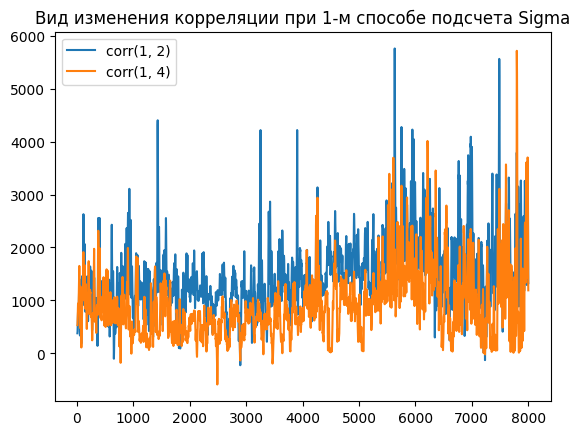

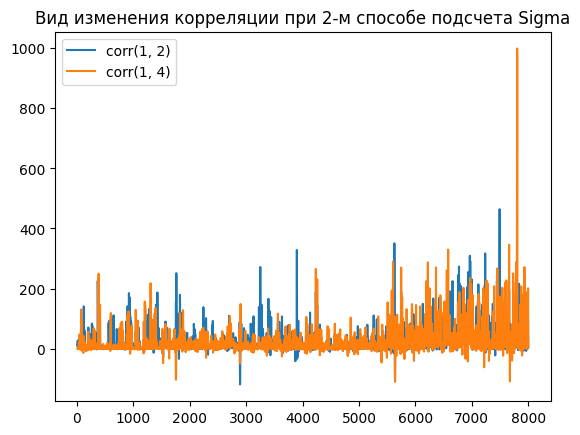

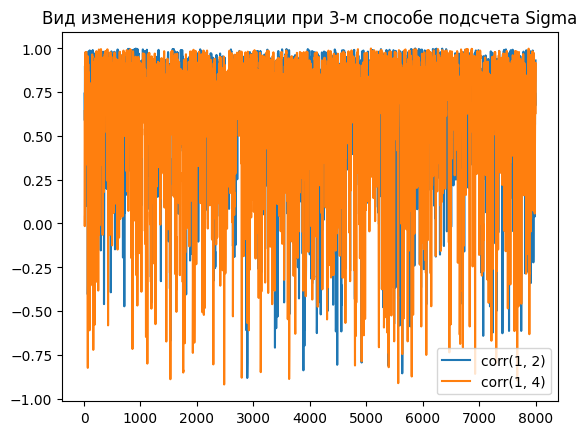

In [65]:
plt.plot(corr_ts_1.iloc[:, 0], label="corr(1, 2)")
plt.plot(corr_ts_1.iloc[:, 2], label="corr(1, 4)")
plt.title("Вид изменения корреляции при 1-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[:, 0], label="corr(1, 2)")
plt.plot(corr_ts_2.iloc[:, 2], label="corr(1, 4)")
plt.title("Вид изменения корреляции при 2-м способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[:, 0], label="corr(1, 2)")
plt.plot(corr_ts_3.iloc[:, 2], label="corr(1, 4)")
plt.title("Вид изменения корреляции при 3-м способе подсчета Sigma")
plt.legend()
plt.show()

In [66]:
forecast_corr_1, actual_corr_1 = forecast(corr_ts_1, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_2, actual_corr_2 = forecast(corr_ts_2, n_past, num_of_corr_series, train_test_ratio)
forecast_corr_3, actual_corr_3 = forecast(corr_ts_3, n_past, num_of_corr_series, train_test_ratio)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [67]:
print(forecast_corr_1)

                0            1            2             3            4  \
0     1492.419678  1422.511230  1033.946289   2757.766357  1805.302124   
1     1375.370850  1267.898682   805.305725   2446.006836  1634.289795   
2     1306.934692  1150.377930   561.924194   2321.070801  1538.812988   
3     1492.911011  1206.553101   494.147858   2492.181152  1691.788086   
4     1872.210083  1388.491333   549.705200   2667.157715  2006.537598   
...           ...          ...          ...           ...          ...   
1583  2708.972656  2229.749268  3232.764160  16023.424805  2213.685791   
1584  2427.427490  2058.833740  2905.435303  14137.833984  2075.423584   
1585  2044.002441  1782.301147  2437.999512  11363.922852  1875.226685   
1586  1718.744019  1511.404297  2014.498901   8595.789062  1701.630249   
1587  1540.463501  1340.439575  1717.699585   6503.491699  1626.033203   

                5             6            7             8             9  
0     1062.209595   2599.335693  126

In [69]:
MAE_avg_1, MSE_avg_1 = MAE_MSE_avg(forecast_corr_1, actual_corr_1, num_of_corr_series) # вычисление средних ошибок прогноза MAE, MSE
MAE_avg_2, MSE_avg_2 = MAE_MSE_avg(forecast_corr_2, actual_corr_2, num_of_corr_series)
MAE_avg_3, MSE_avg_3 = MAE_MSE_avg(forecast_corr_3, actual_corr_3, num_of_corr_series)

In [70]:
print(f'Первый способ: MAE = {MAE_avg_1}, MSE = {MSE_avg_1}')
print(f'Второй способ: MAE = {MAE_avg_2}, MSE = {MSE_avg_2}')
print(f'Третий способ: MAE = {MAE_avg_3}, MSE = {MSE_avg_3}')

Первый способ: MAE = 406.6994789089051, MSE = 569857.6955291856
Второй способ: MAE = 75.50748922741755, MSE = 16975.305351853083
Третий способ: MAE = 0.10509393127278983, MSE = 0.02772369210331792


In [71]:
forecast_corr_1 = forecast_corr_1.set_index(forecast_corr_1.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_2 = forecast_corr_2.set_index(forecast_corr_2.index + int(ts_len * train_test_ratio) + L + 1)
forecast_corr_3 = forecast_corr_3.set_index(forecast_corr_3.index + int(ts_len * train_test_ratio) + L + 1)

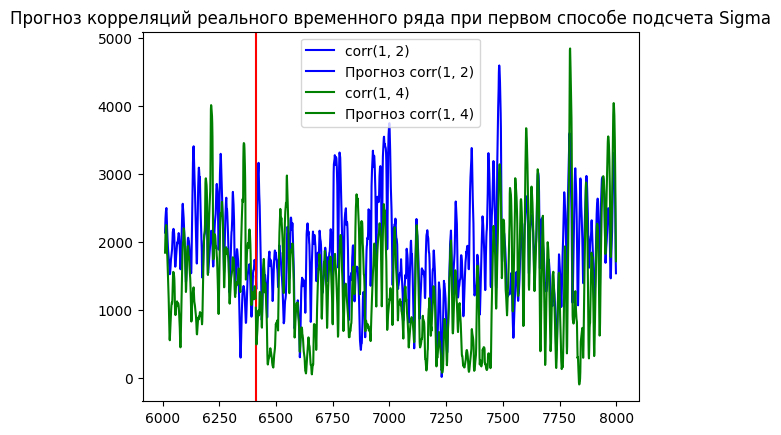

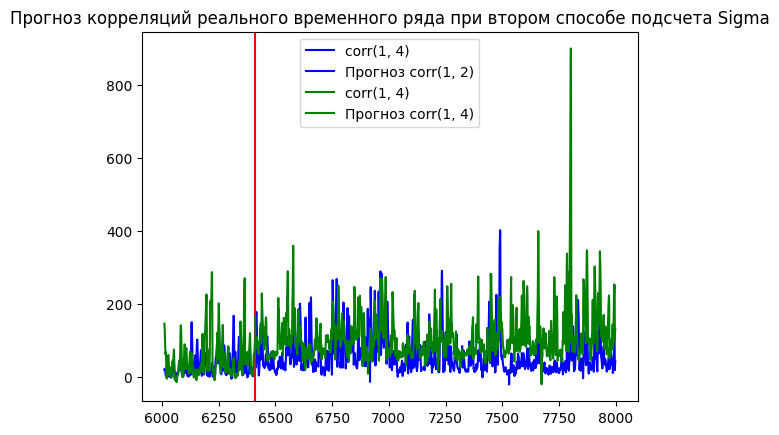

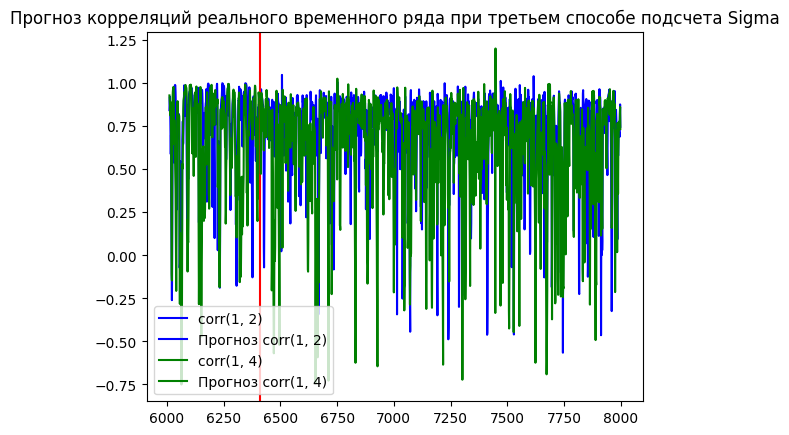

In [73]:
plt.plot(corr_ts_1.iloc[6000:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_1.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_1.iloc[6000:split_point, 2], label="corr(1, 4)", color='g')
plt.plot(forecast_corr_1.iloc[:, 2], label="Прогноз corr(1, 4)", color='g')

plt.title("Прогноз корреляций реального временного ряда при первом способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[6000:split_point, 0], label="corr(1, 4)", color='b')
plt.plot(forecast_corr_2.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_2.iloc[6000:split_point, 2], label="corr(1, 4)", color='g')
plt.plot(forecast_corr_2.iloc[:, 2], label="Прогноз corr(1, 4)", color='g')

plt.title("Прогноз корреляций реального временного ряда при втором способе подсчета Sigma")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[6000:split_point, 0], label="corr(1, 2)", color='b')
plt.plot(forecast_corr_3.iloc[:, 0], label="Прогноз corr(1, 2)", color='b')
plt.axvline(x = split_point + n_past, color='r')

plt.plot(corr_ts_3.iloc[6000:split_point, 2], label="corr(1, 4)", color='g')
plt.plot(forecast_corr_3.iloc[:, 2], label="Прогноз corr(1, 4)", color='g')

plt.title("Прогноз корреляций реального временного ряда при третьем способе подсчета Sigma")
plt.legend()
plt.show()

In [74]:
MAE_per_series_1 = [[] for i in range(num_of_series)]
MAE_per_series_2 = [[] for i in range(num_of_series)]
MAE_per_series_3 = [[] for i in range(num_of_series)]

In [75]:
idx = 0

for i in range(1, num_of_series + 1):
    for j in range(i + 1, num_of_series + 1):
        ytrue_1 = actual_corr_1.iloc[:, idx].values
        yhat_1 = forecast_corr_1.iloc[:, idx].values
        ytrue_2 = actual_corr_2.iloc[:, idx].values
        yhat_2 = forecast_corr_2.iloc[:, idx].values
        ytrue_3 = actual_corr_3.iloc[:, idx].values
        yhat_3 = forecast_corr_3.iloc[:, idx].values
        mae_1 = MAE(ytrue_1, yhat_1)
        mae_2 = MAE(ytrue_2, yhat_2)
        mae_3 = MAE(ytrue_3, yhat_3)
        MAE_per_series_1[i - 1].append(mae_1)
        MAE_per_series_1[j - 1].append(mae_1)
        MAE_per_series_2[i - 1].append(mae_2)
        MAE_per_series_2[j - 1].append(mae_2)
        MAE_per_series_3[i - 1].append(mae_3)
        MAE_per_series_3[j - 1].append(mae_3)
        idx += 1

In [76]:
MAE_avg_per_series_1 = []
MAE_avg_per_series_2 = []
MAE_avg_per_series_3 = []

In [77]:
for i in range(num_of_series):
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    for j in range(num_of_series - 1):
        sum_1 += MAE_per_series_1[i][j]
        sum_2 += MAE_per_series_2[i][j]
        sum_3 += MAE_per_series_3[i][j]

    MAE_avg_per_series_1.append(sum_1 / (num_of_series - 1))
    MAE_avg_per_series_2.append(sum_2 / (num_of_series - 1))
    MAE_avg_per_series_3.append(sum_3 / (num_of_series - 1))

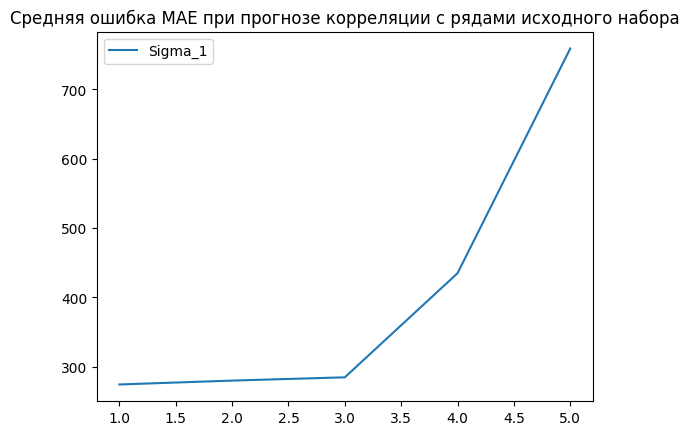

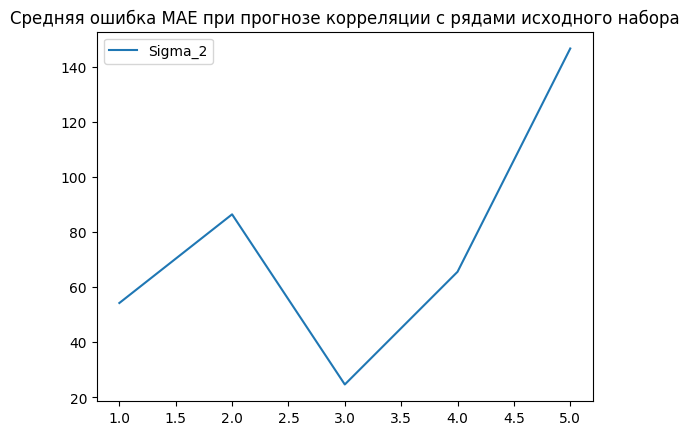

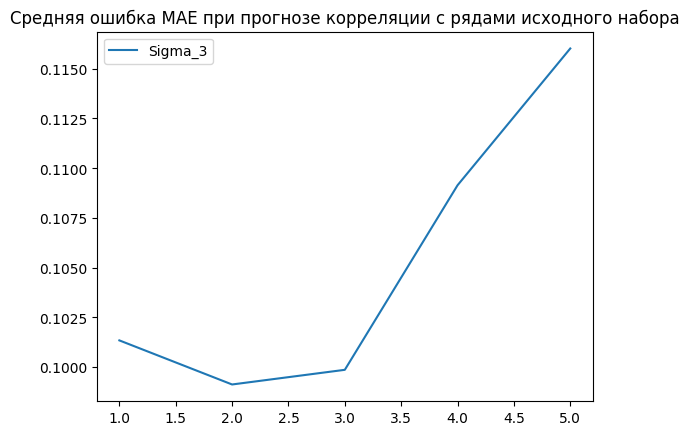

In [78]:
plt.plot([i for i in range(1, num_of_series + 1)], MAE_avg_per_series_1, label="Sigma_1")
plt.title("Средняя ошибка MAE при прогнозе корреляции с рядами исходного набора")
plt.legend()
plt.show()

plt.plot([i for i in range(1, num_of_series + 1)], MAE_avg_per_series_2, label="Sigma_2")
plt.title("Средняя ошибка MAE при прогнозе корреляции с рядами исходного набора")
plt.legend()
plt.show()

plt.plot([i for i in range(1, num_of_series + 1)], MAE_avg_per_series_3, label="Sigma_3")
plt.title("Средняя ошибка MAE при прогнозе корреляции с рядами исходного набора")
plt.legend()
plt.show()

In [79]:
variance = df.var()
print(variance)

2017     108.561278
2018     278.797279
2019     160.611680
2020     327.073445
2021    2670.579148
dtype: float64


<Axes: >

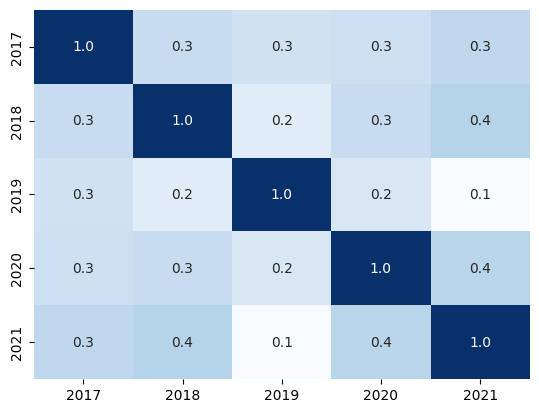

In [80]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')